<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="6"> TAF MCE - 2021</span></p>
<p><font size="5">  UE C - Numerical Methods </font></p>
<p></p>
<p><font size="4">  Parallel computing in Julia </font></p>
</p></br>
<p><b><font size="4"> By Martina María BALBI ANTUNES and Kevin MICHALEWICZ </font></b></p>
</p>
</CENTER>

In [1]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images
using Distributed
CPU_CORES = 4 # number of cores on the machine
addprocs(CPU_CORES - 1);
@everywhere using LinearAlgebra

using Distributed

pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

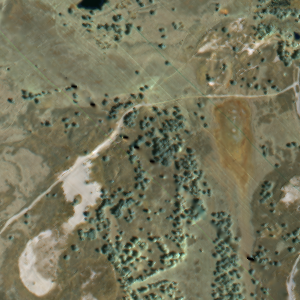

In [2]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

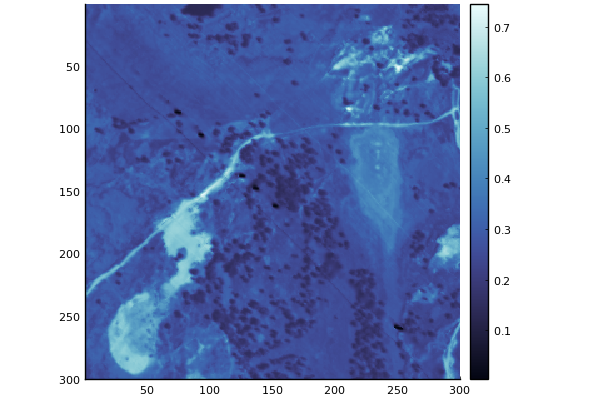

In [3]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

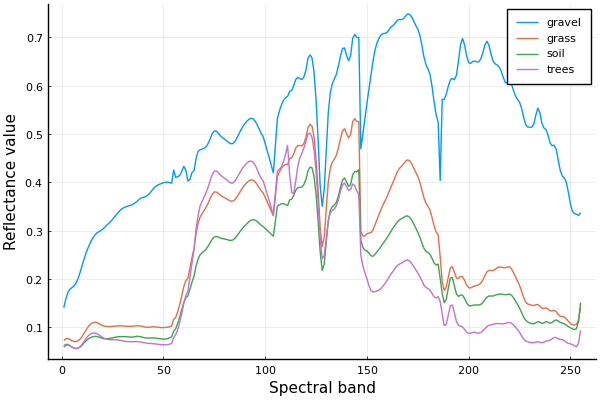

In [4]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [5]:
img_small = img[1:100,1:100,:]; # use a small crop of the image first
# img_small = copy(img);

# Introduction

The idea is to implement a projected gradient descent algorithm coded by us in a standard serial way and then using parallelization. After that, we perform a similar analysis using Julia libraries. 

# Serial computing

## Projected gradient descent algorithm

In [6]:
size(img_small)

(100, 100, 255)

In [7]:
#X = reshape(img_small, size(img_small)[1]^2, 255)' # we work with images that are vectors
X = reshape(img, size(img)[1]^2, 255)'
size(X)

(255, 90000)

In [8]:
@everywhere function ProjectedGradientDescent(X,S,f,∇f,f_stepsize)
    
    """
    projected gradient descent
    IN:
    ---
    X: data matrix
    S: endmember matrix
    f, ∇f: function to be minimized and its gradient
    OUT:
    ----
    A: abundance matrix
    """
    
    # Initialization 
    N, p = size(X,2), size(S,2)
    A_init = max.(zeros(p,N),rand(p,N))
    A = A_init
    precision = 1.e-4
    δ = 1 # we compute the norm of the difference of A between iterations i and i+1
    opt_stepsize =  0.012 # 2/opnorm(S'*S)
    final_stepsize = f_stepsize
    max_iter = 5000
    nb_iter_pgrad = 0 # number of iterations
    
    # Loop
    while ((δ > precision) || (δ == 0.0)) & (nb_iter_pgrad < max_iter)
        
        nb_iter_pgrad += 1
        A_hat = max.(zeros(p,N), A - opt_stepsize * ∇f(A,X,S))
        δ = norm(A - A_hat)
        A = A_hat
    end
    
    # Final iteration
    A = A./sum(A, dims=1)
    A = max.(zeros(p,N), A - final_stepsize * ∇f(A,X,S))
    A = A./sum(A, dims=1)
    
    return A
    
end

In [9]:
function plotFourMaps(A)
    heatmaps = []
    labels = ["Gravel", "Grass", "Soil", "Trees"]
    for i in 1:size(S,2)
        push!(heatmaps, heatmap(reshape(A[i,:], Int(sqrt(N)), Int(sqrt(N))), yflip=true, aspect_ratio=1, c=:ice, title=labels[i]))
    end
    plot(heatmaps...,layout=size(S,2), size=(800,600))
end

plotFourMaps (generic function with 1 method)

In [10]:
using LinearAlgebra: opnorm, norm

N = size(X,2)
S = sources
A = zeros(size(S,2), N)
f_stepsize = 0.005
@everywhere f(A,X,S)= (1/2)*tr((X-S*A)'*(X-S*A))
@everywhere ∇f(A,X,S) = S'*(S*A - X)

@time begin
    for j = 1:N
        A[:,j] = ProjectedGradientDescent(X[:,j],S,f,∇f,f_stepsize)
    end
end

In [11]:
A[:,1]

4-element Vector{Float64}:
 0.024796070202478475
 0.4330727381933598
 0.15186071734784712
 0.3902704742563146

In [12]:
sum(reshape(A[1,:], Int(sqrt(N)), Int(sqrt(N))))

8652.922990995316

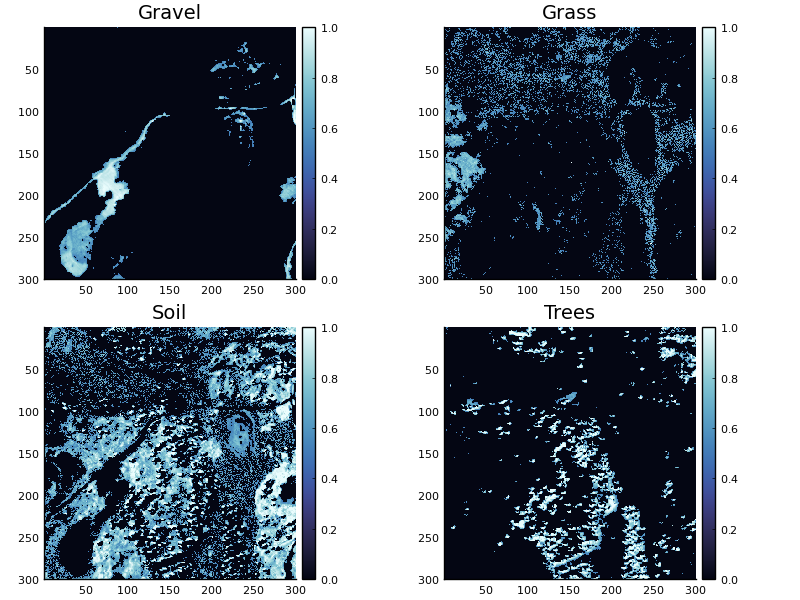

In [13]:
plotFourMaps(A.*(A.>0.5))

In [14]:
# This option takes a lot of time

A = zeros(size(S,2), N)
f_stepsize = 0.0005

@time begin
    A = ProjectedGradientDescent(X,S,f,∇f,f_stepsize)
end

1109.296365 seconds (515.33 k allocations: 1.749 TiB, 8.85% gc time, 0.02% compilation time)


4×90000 Matrix{Float64}:
 0.00214245  0.00251104  0.00205251  …  0.0423701  0.0668239  0.0576895
 0.575087    0.551168    0.568921       0.190495   0.10815    0.114304
 0.00112557  0.0922676   0.202234       0.767135   0.825026   0.828007
 0.421645    0.354053    0.226792       0.0        0.0        0.0

In [15]:
sum(A)

90000.0

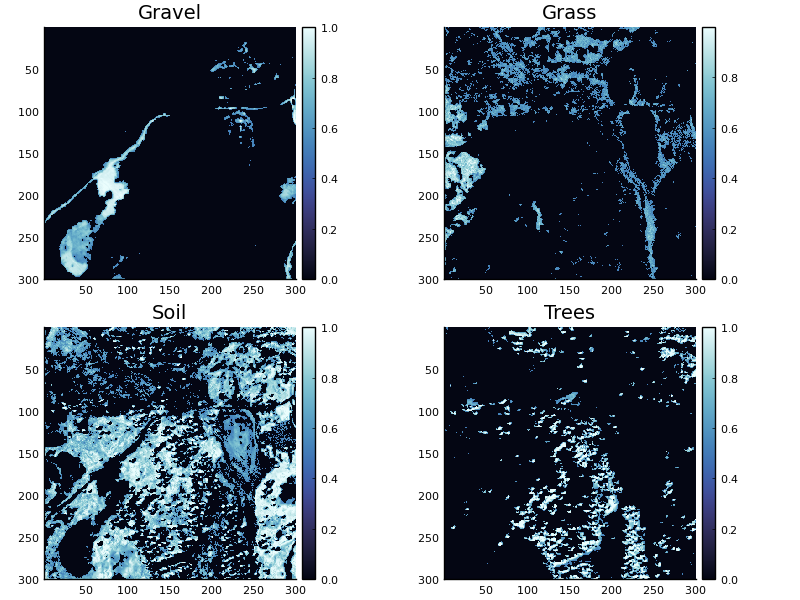

In [16]:
plotFourMaps(A.*(A.>0.5))

In [33]:
A = zeros(size(S,2), N)
f_stepsize = 0.0005

@time begin
    for j = 1:N÷8:N
        A[:,j:j+N÷8-1] = ProjectedGradientDescent(X[:,j:j+N÷8-1],S,f,∇f,f_stepsize)
    end
end

1
11251
22501
33751
45001
56251
67501
78751
460.852377 seconds (641.40 k allocations: 1.749 TiB, 2.87% gc time)


In [36]:
sum(A)

90000.0

In [37]:
A

4×90000 Matrix{Float64}:
 0.00214198  0.0021987   0.0018257  …  0.0422684  0.0668336  0.0577971
 0.575191    0.632393    0.627704      0.207429   0.035142   0.0694606
 0.0011254   0.00115117  0.137172      0.750303   0.898024   0.872742
 0.421542    0.364257    0.233298      0.0        0.0        0.0

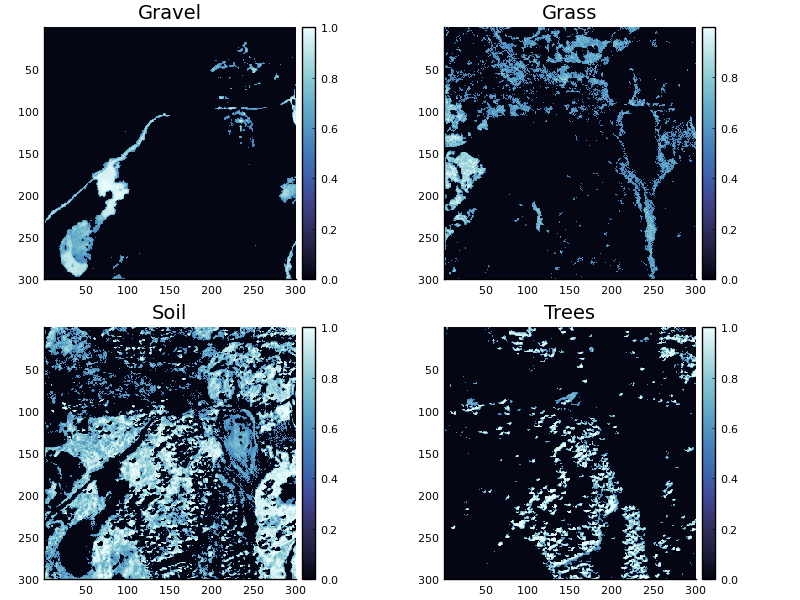

In [38]:
plotFourMaps(A.*(A.>0.5))

## Julia libraries

# Parallel computing

## Projected gradient descent algorithm

In [17]:
using Distributed: pmap
f_stepsize = 0.005

A = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f,f_stepsize), [X[:,j] for j = 1:N]);

139.091486 seconds (10.03 M allocations: 879.217 MiB, 0.13% gc time, 0.64% compilation time)


In [18]:
A = hcat(A...)

4×90000 Matrix{Float64}:
 0.0247971  0.0255989  0.0247413  …  0.0178697  0.0473782  0.0389919
 0.433065   0.47828    0.408035      0.303956   0.172907   0.17269
 0.151759   0.159317   0.357815      0.678174   0.779715   0.788318
 0.390379   0.336804   0.209408      0.0        0.0        0.0

In [19]:
size(A)

(4, 90000)

In [20]:
sum(reshape(A[1,:], Int(sqrt(N)), Int(sqrt(N))))

8650.926311587395

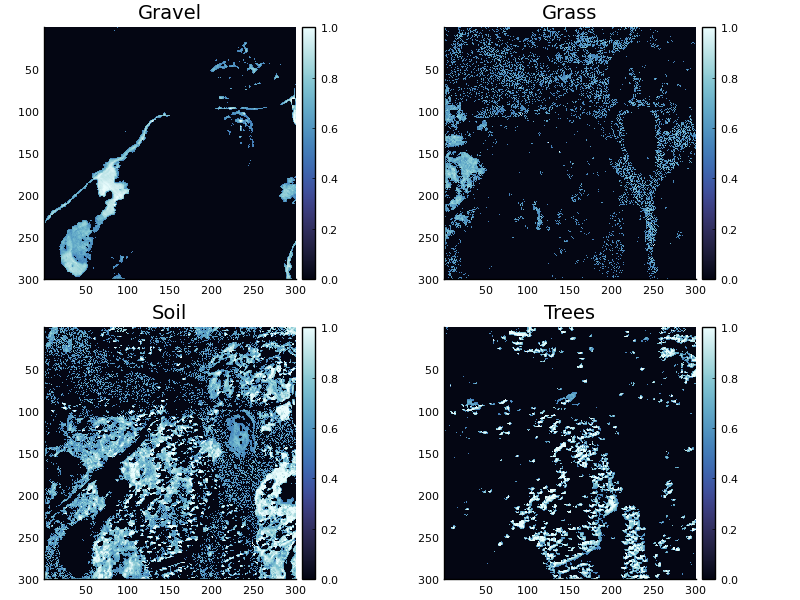

In [21]:
plotFourMaps(A.*(A.>0.5))

In [39]:
f_stepsize = 0.0005

A = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f,f_stepsize), [X[:,j:j+N÷8-1] for j = 1:N÷8:N]);

250.284934 seconds (3.68 M allocations: 402.279 MiB, 0.03% gc time, 0.32% compilation time)


In [40]:
A = hcat(A...)
size(A)

(4, 90000)

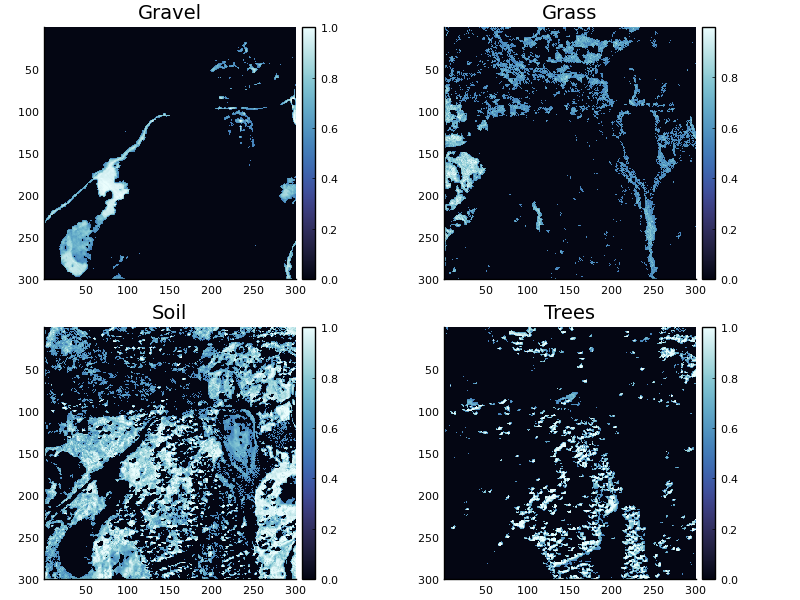

In [41]:
plotFourMaps(A.*(A.>0.5))

## Julia libraries